# Create sum and product kernels with exsisting kernels


### Combine different kernels for better test power on certain data types

In [1]:
import numpy as np
import scipy.stats as stats
import torch
import matplotlib.pyplot as plt
import tensorflow as tf

backend = 'pytorch'

from alibi_detect.cd import MMDDrift
if backend == 'pytorch':
    from alibi_detect.utils.pytorch.kernels import GaussianRBF, Periodic, AveragedKernel, DimensionSelectKernel
elif backend == 'tensorflow':
    from alibi_detect.utils.tensorflow.kernels import GaussianRBF, Periodic, AveragedKernel, DimensionSelectKernel
else:
    raise ValueError('Backend {} not supported'.format(backend))

import matplotlib.pyplot as plt
%matplotlib inline

2022-08-18 11:16:03.693515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 11:16:03.693561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-18 11:16:09.361482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-18 11:16:09.361658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 11:16:09.361739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

In [2]:
def get_sin(N):
    c_0 = np.random.uniform(0, 168, N)
    x_0 = np.sin(c_0 / (12 / np.pi)) + np.random.normal(0, 0.1, N)

    c_1 = stats.beta.rvs(a=1.2, b=1.2, size=N) * 24 + np.random.choice([0, 24, 48, 72, 96, 120, 144], size=N)
    x_1 = np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) < 12) + \
        np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) >= 12) * 1.25 + \
            + np.random.normal(0, 0.1, N)
        
    x_ref = np.hstack([c_0.reshape(-1, 1), x_0.reshape(-1, 1)])
    x_test = np.hstack([c_1.reshape(-1, 1), x_1.reshape(-1, 1)])    
        
    return x_ref, x_test

In [3]:
x_ref, x_test = get_sin(N=1000)

### Here we create two simple datasets with waves and therefore have two features, the test data shows clear drift around the wave through.

(-1.5, 1.5)

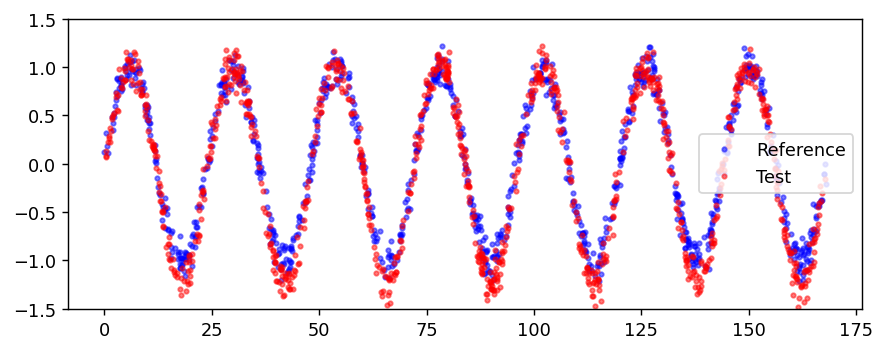

In [4]:
plt.figure(figsize=(8, 3), dpi=128)
plt.plot(x_ref[:, 0], x_ref[:, 1], 'bo', alpha=0.5, markersize=2.5, label='Reference')
plt.plot(x_test[:, 0], x_test[:, 1], 'ro', alpha=0.5, markersize=2.5, label='Test')
plt.legend()
plt.ylim(-1.5, 1.5)

### If we use standard RBF kernel on both features with the MMD drift detector, we can see that the drift is not detected.

In [5]:
Kernel_RBF = GaussianRBF()

In [6]:
cd_RBF = MMDDrift(x_ref=x_ref,
                  backend=backend,
                  kernel=Kernel_RBF)

No GPU detected, fall back on CPU.


In [7]:
preds_RBF = cd_RBF.predict(x_test)
preds_RBF

{'data': {'is_drift': 0,
  'distance': -0.00032591944848670007,
  'p_val': 0.5600000023841858,
  'threshold': 0.05,
  'distance_threshold': array(0.00219562, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'pytorch'}}

### To facilitate our knowledge that the data contain waves, we use a combined kernel that is averaged from two kernels. The first kernel is a periodic kernel with a specified period of 24 and only working on the first feature. The second kernel is a RBF kernel with a infered bandwidth and only working on the second feature.

In [8]:
if backend == 'pytorch':
    Kernel_0 = DimensionSelectKernel(Periodic(tau=torch.tensor([24.0])), active_dims=[0])
    Kernel_1 = DimensionSelectKernel(GaussianRBF(), active_dims=[1])
elif backend == 'tensorflow':
    Kernel_0 = DimensionSelectKernel(Periodic(tau=tf.convert_to_tensor([24.0])), active_dims=[0])
    Kernel_1 = DimensionSelectKernel(GaussianRBF(), active_dims=[1])

In [9]:
Kernel_avg = AveragedKernel(Kernel_0, Kernel_1)

In [10]:
cd_avg = MMDDrift(x_ref=x_ref,
                  backend=backend,
                  kernel=Kernel_avg)

No GPU detected, fall back on CPU.


### We can see the drift is detected with the combined kernel.

In [11]:
preds_avg = cd_avg.predict(x_test)
preds_avg

{'data': {'is_drift': 1,
  'distance': 0.006368878019042512,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00098101, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'pytorch'}}

### The kernel, its compments and asscociated parameters can be inspected as follows:


In [12]:
print(cd_avg._detector.kernel)
print(cd_avg._detector.kernel.kernel_a)
print(cd_avg._detector.kernel.kernel_a.kernel)

AveragedKernel(
  (kernel_a): DimensionSelectKernel(
    (kernel): Periodic()
  )
  (kernel_b): DimensionSelectKernel(
    (kernel): GaussianRBF()
  )
)
DimensionSelectKernel(
  (kernel): Periodic()
)
Periodic()


In [13]:
print(Kernel_avg.kernel_a.kernel.tau)
print(Kernel_avg.kernel_a.kernel.sigma)

tensor([24.])
tensor([4.9818], dtype=torch.float64)


In [14]:
Kernel_avg.kernel_b.kernel.sigma

tensor([0.5243], dtype=torch.float64)